# Machine learning to predict molecule properties : solubility



Laurent Cetinsoy

The solubility of molecules is an important property in many applications like for drug selection or for compound selection for battery designes (no link to health).

Being able to predict the solubility of a molecule from its formula instead of having to make measuring experiment in an important aspect to enhanced fatester molecule discovery.

In this notebook we will do basic solubility prediction with machine learning models and rdkit


Install the python rdkit package with pip or conda

cf https://www.rdkit.org/docs/index.html

References :

- https://www.rdkit.org/docs/GettingStartedInPython.html
- https://www.rdkit.org/docs/Cookbook.html



In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 12.5 MB/s eta 0:00:00


In [15]:
import rdkit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import Descriptors

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Atom and Molecule representations with Rdkit

Rdkit is a package allowing to work with molecule data and their representation. It is very useful to gather information about atom and molecules. Especially about their physical and chemical properties. In this notebook we will learn about them

For basic manipulations, the main submodule is **Chem**



### Smile representation

Smile lets represent molecules with text strings.


Like many representations in chemistry we do not represent hydrogene atoms, indeed we can deduce it from the rest of the data.


The following code define the Smile Representation of a very simple molecule. We will try to find out more

In [3]:
smile_molecule = "C"

From the rdkit.Chem submodule, import MolFromSmiles

Using MolFromSmiles, load smile_molecule into a rdkit molecule. Store it in a variable named first_mol

In [4]:
first_mol = Chem.MolFromSmiles(smile_molecule)

display the type of first_mol

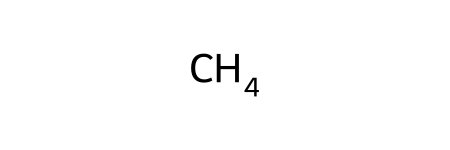

In [5]:
first_mol

With the dir function, list the public methods of the object instance first_mol

In [6]:
methods = dir(first_mol)
methods

['AddConformer',
 'ClearComputedProps',
 'ClearProp',
 'Compute2DCoords',
 'ComputeGasteigerCharges',
 'Debug',
 'GetAromaticAtoms',
 'GetAtomWithIdx',
 'GetAtoms',
 'GetAtomsMatchingQuery',
 'GetBondBetweenAtoms',
 'GetBondWithIdx',
 'GetBonds',
 'GetBoolProp',
 'GetConformer',
 'GetConformers',
 'GetDoubleProp',
 'GetIntProp',
 'GetNumAtoms',
 'GetNumBonds',
 'GetNumConformers',
 'GetNumHeavyAtoms',
 'GetProp',
 'GetPropNames',
 'GetPropsAsDict',
 'GetRingInfo',
 'GetStereoGroups',
 'GetSubstructMatch',
 'GetSubstructMatches',
 'GetUnsignedProp',
 'HasProp',
 'HasQuery',
 'HasSubstructMatch',
 'NeedsUpdatePropertyCache',
 'RemoveAllConformers',
 'RemoveConformer',
 'SetBoolProp',
 'SetDoubleProp',
 'SetIntProp',
 'SetProp',
 'SetUnsignedProp',
 'ToBinary',
 'UpdatePropertyCache',
 '__DebugMol',
 '__GetSubstructMatch',
 '__GetSubstructMatches',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__geta

Among all the methods, you should have found a method allowing you to get the number of atoms.
Call it and store the result in a variable n_atoms and display it

In [7]:
 n_atoms = first_mol.GetNumAtoms()

Using Draw from rdkit.Chem module, draw the moldule

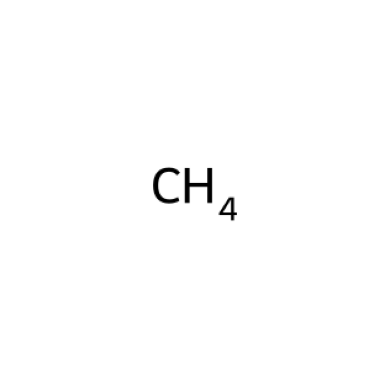

In [16]:
mol_image = Chem.Draw.MolToImage(first_mol)

plt.imshow(mol_image)
plt.axis('off')
plt.show()

Do you see a contradiction between the MolToImage and GetNumOfAtoms ? Can you explain why below


No, because there's only one molecule

We will tell rdkit to clone the molecule but to add the hydrogen atoms now.
Create a new molecule from first_mol using the method AddHs.
Store it in a variable named mol2

In [18]:
mol2 = Chem.AddHs(first_mol)

Display the number of Atoms now

In [19]:
mol2.GetNumAtoms()

5

Display the number of Heavy Atoms (check the methods from dir output)

In [20]:
mol2.GetNumHeavyAtoms()

1

Is it coherent ?

Yes, it is coherent to have 5 atoms in total and only 1 heavy atom, depending on the molecule

With the MolToImage function of the Draw package, display the molecule mol2.

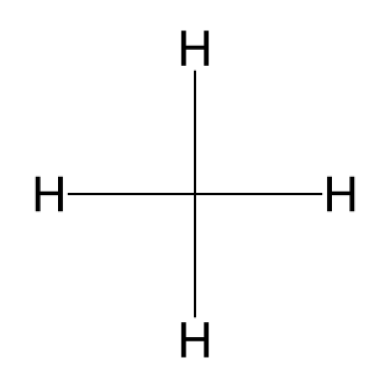

In [21]:
mol_image_2 = Chem.Draw.MolToImage(mol2)

plt.imshow(mol_image_2)
plt.axis('off')
plt.show()

Let's look at a real molecule now.

The following string contains the SMILE representation of the paracetamol molecule

In [25]:
smile = 'CC(=O)NC1=CC=C(O)C=C1'

Using the MolFromSmiles function, create a molecule from the smile representation and print its types

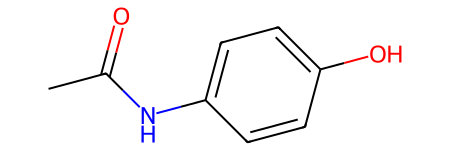

In [26]:
mol3 = rdkit.Chem.MolFromSmiles(smile)
# Visualize its structure
mol3

With the MolToImage function of the Draw package, display the molecule

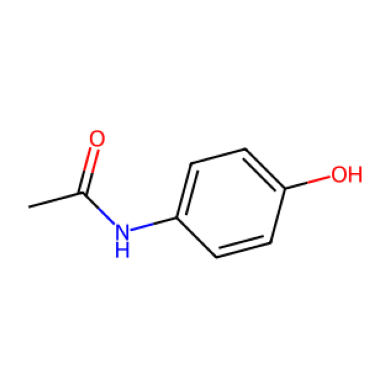

In [27]:
mol_image_3 = Chem.Draw.MolToImage(mol3)

plt.imshow(mol_image_3)
plt.axis('off')
plt.show()

You can get the Number of atoms of the molecules and the list of atoms with the methods GetNumAtoms and GetAtoms.

Print the number of atoms of the molecule

In [28]:
mol3.GetNumAtoms()

11

In [29]:
mol3.GetAtoms()

If you compare to the picture, you may see that the number of atoms is not 11. What is the total number and why rdkit do not give the same answer ?

RDKit uses implicit hydrogens. This means it does not explicitly count or display the hydrogens unless you add them manually using Chem.AddHs

Print the list of each atoms

In [30]:
for atoms in mol3.GetAtoms() :
  print(atoms.GetSymbol())

C
C
O
N
C
C
C
C
O
C
C


Store the number of bonds of the molecule in **n_bond** (look which method can be used for that) and print

In [ ]:
n_bond = mol3.GetNumBonds()

For each bond, print if the bond is single or double

In [32]:
for atoms in mol3.GetBonds() :
  print(atoms.GetBondType())

SINGLE
DOUBLE
SINGLE
SINGLE
AROMATIC
AROMATIC
AROMATIC
SINGLE
AROMATIC
AROMATIC
AROMATIC


### Reading molecule data from file

Apart SMILES, .SDF and .Mol are also the common formats to save molecules. RDKit provides also functionalities to read these files.


Morphine is an opioid agonist used for the relief of moderate to severe acute and chronic pain. The chemical information of this drug can be found at
https://go.drugbank.com/structures/small_molecule_drugs/DB00295.sdf


Download this file and save it in a folder.




SDF files can contain one or more molecules. To load them, you can use SDMolSupplier. When you use it it will return you an object that looks like a list.

Read the file that you've downloaded using "rdkit.Chem.SDMolSupplier" and get the first molecule (the only one) and  store it in a variable named **morphine**



In [43]:
morphine_molecule = rdkit.Chem.SDMolSupplier('/content/DB00295.sdf')
morphine = morphine_molecule[0]
morphine_molecule_fingerprint = AllChem.GetMorganFingerprintAsBitVect(morphine_molecule[0], 2)

[21:24:44] DEPRECATION WARNING: please use MorganGenerator


Display its type

In [44]:
type(morphine)

rdkit.Chem.rdchem.Mol

Display the picture of the molecule


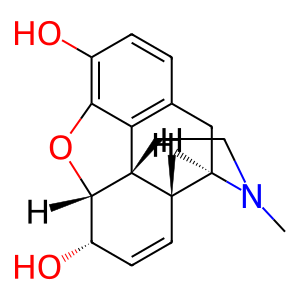

In [45]:
Chem.Draw.MolToImage(morphine)

Display the number of atoms and the number of bonds

In [46]:
morphine.GetNumAtoms()

21

In [47]:
morphine.GetNumBonds()

25

### Descriptors


Molecules are also described by a set of physiochemical descriptors like
- the log partition coefficient,
- the polar surface area ... that describe the molecule's structure.


RDKit provides utilities that allow us to compute descriptor of molecules.

The rdkit.Chem.Descriptors module and its sub module let us compute molecule descriptors.

the rdkit.Chem.Descriptors module has an attribute name \_descList, display it. It contains a list of tuple. Each tuple has the name of the physical property, and function associated to it to compute the given property

In [49]:
desc_list = Descriptors._descList

# Print the list of tuples (property name and associated function)
for desc in desc_list:
    print(desc)

('MaxAbsEStateIndex', <function MaxAbsEStateIndex at 0x7cf8d0339090>)
('MaxEStateIndex', <function MaxEStateIndex at 0x7cf8d0338f70>)
('MinAbsEStateIndex', <function MinAbsEStateIndex at 0x7cf8d0339120>)
('MinEStateIndex', <function MinEStateIndex at 0x7cf8d0339000>)
('qed', <function qed at 0x7cf8d033beb0>)
('SPS', <function SPS at 0x7cf8d037c3a0>)
('MolWt', <function <lambda> at 0x7cf8d037c9d0>)
('HeavyAtomMolWt', <function HeavyAtomMolWt at 0x7cf8d037ca60>)
('ExactMolWt', <function <lambda> at 0x7cf8d037caf0>)
('NumValenceElectrons', <function NumValenceElectrons at 0x7cf8d037cb80>)
('NumRadicalElectrons', <function NumRadicalElectrons at 0x7cf8d037cc10>)
('MaxPartialCharge', <function MaxPartialCharge at 0x7cf8d037cd30>)
('MinPartialCharge', <function MinPartialCharge at 0x7cf8d037cdc0>)
('MaxAbsPartialCharge', <function MaxAbsPartialCharge at 0x7cf8d037ce50>)
('MinAbsPartialCharge', <function MinAbsPartialCharge at 0x7cf8d037cee0>)
('FpDensityMorgan1', <function FpDensityMorgan1 a

Compute all descriptors in the _descList list of the paracetamol molecule using the MoleculeDescriptors.MolecularDescriptorCalculator class

In [51]:
paracetamol_molecule = rdkit.Chem.MolFromSmiles("CC(=O)NC1=CC=C(O)C=C1")
descriptor_calculator = rdkit.ML.Descriptors.MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Chem.Descriptors._descList])
print(descriptor_calculator.CalcDescriptors(paracetamol_molecule))

(10.524468537414966, 10.524468537414966, 0.11510204081632636, -0.11510204081632636, 0.5950261967780849, 9.181818181818182, 151.165, 142.093, 151.063328528, 58, 0, 0.22074743631242583, -0.5079643157925783, 0.5079643157925783, 0.22074743631242583, 1.3636363636363635, 1.9090909090909092, 2.3636363636363638, 16.25468871437965, 10.280190859964755, 1.9280360590359866, -1.9945540738765895, 2.12524757916018, -2.04401131261029, 5.88095478459792, -0.11373578338266109, 1.9291266251851134, 2.7362980721056545, 253.29949758389105, 8.267584713501616, 6.164862962722325, 6.164862962722325, 5.1815405503520555, 3.2490981480278296, 3.2490981480278296, 2.228060242189872, 2.228060242189872, 1.1876733148984595, 1.1876733148984595, 0.7480265991539318, 0.7480265991539318, -1.5099999999999998, 285.51074052739676, 7.595374077976819, 3.0531381005525, 2.292303972882069, 64.66690538413799, 10.423315998847038, 5.749511833283905, 0.0, 5.907179729351506, 0.0, 0.0, 4.794537184071822, 0.0, 0.0, 0.0, 0.0, 24.265468273846

Display the names and the fvalues of the descriptors

In [60]:
from rdkit.Chem.Descriptors import _descList


paracetamol_smiles = 'CC(=O)NC1=CC=C(O)C=C1'
paracetamol_molecule = rdkit.Chem.MolFromSmiles(paracetamol_smiles)

desc_calculator = MolecularDescriptorCalculator([desc[0] for desc in _descList])

descriptors = desc_calculator.CalcDescriptors(paracetamol_molecule)

descriptor_dict = dict(zip([desc[0] for desc in _descList], descriptors))
for desc_name, value in descriptor_dict.items():
    print(f"{desc_name}: {value}")

MaxAbsEStateIndex: 10.524468537414966
MaxEStateIndex: 10.524468537414966
MinAbsEStateIndex: 0.11510204081632636
MinEStateIndex: -0.11510204081632636
qed: 0.5950261967780849
SPS: 9.181818181818182
MolWt: 151.165
HeavyAtomMolWt: 142.093
ExactMolWt: 151.063328528
NumValenceElectrons: 58
NumRadicalElectrons: 0
MaxPartialCharge: 0.22074743631242583
MinPartialCharge: -0.5079643157925783
MaxAbsPartialCharge: 0.5079643157925783
MinAbsPartialCharge: 0.22074743631242583
FpDensityMorgan1: 1.3636363636363635
FpDensityMorgan2: 1.9090909090909092
FpDensityMorgan3: 2.3636363636363638
BCUT2D_MWHI: 16.25468871437965
BCUT2D_MWLOW: 10.280190859964755
BCUT2D_CHGHI: 1.9280360590359866
BCUT2D_CHGLO: -1.9945540738765895
BCUT2D_LOGPHI: 2.12524757916018
BCUT2D_LOGPLOW: -2.04401131261029
BCUT2D_MRHI: 5.88095478459792
BCUT2D_MRLOW: -0.11373578338266109
AvgIpc: 1.9291266251851134
BalabanJ: 2.7362980721056545
BertzCT: 253.29949758389105
Chi0: 8.267584713501616
Chi0n: 6.164862962722325
Chi0v: 6.164862962722325
Chi1

### Fingerprinting


A chemical structure can be characterized by a set of numerical values known as molecular fingerprints. They may be 2D Fragment-based fingerprints presented by bit arrays of 0s and 1s wherein each bit position indicates the presence or absence of structural fragments.


The RDKit has a variety of built-in functionality for generating molecular fingerprints and then using them to calculate molecular similarity. In this exercise, we will generate the fingerprints for parcetamol and aspirin that are two popular drugs used for pains.





With the help of rdkit.Chem.AllChem.GetMorganFingerprintAsBitVect, compute its fingerprint as a bit vector.

In [61]:
paracetamol_molecule = rdkit.Chem.MolFromSmiles("CC(=O)OC1=CC=CC=C1C(O)=O")
paracetamol_molecule_fingerprint = AllChem.GetMorganFingerprintAsBitVect(paracetamol_molecule, 2, nBits=1024)

[21:37:47] DEPRECATION WARNING: please use MorganGenerator


Display its type

In [62]:
type(paracetamol_molecule_fingerprint)

rdkit.DataStructs.cDataStructs.ExplicitBitVect

With the DataStructs module convert it to a numpy vector and display it shape and display it

In [64]:
paracetamol_molecule_fingerprint_vector = np.zeros((0, ), dtype=np.int8)
DataStructs.ConvertToNumpyArray(paracetamol_molecule_fingerprint, paracetamol_molecule_fingerprint_vector)
paracetamol_fingerprint_vector_non_zero = np.nonzero(paracetamol_molecule_fingerprint_vector)
paracetamol_fingerprint_vector_non_zero

(array([  11,   23,   33,   64,  175,  356,  386,  389,  423,  444,  456,
         592,  650,  695,  705,  726,  751,  807,  849,  893,  909,  946,
         967, 1017]),)

Create a function smiles_to_np_morganfingerprinting which takes a smile representation and gives back the numpy version of the morgan finger_printing

In [76]:
def smiles_to_np_morganfingerprinting(smile):
  molecule = rdkit.Chem.MolFromSmiles(smile)
  fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule, 2, nBits=1024)
  fingerprint_vector = np.zeros((0, ), dtype=np.int8)
  DataStructs.ConvertToNumpyArray(fingerprint, fingerprint_vector)
  return fingerprint_vector

Compute the morgan finger printing of the aspirin (CC(=O)OC1=CC=CC=C1C(O)=O) and paracetamol (CC(=O)NC1=CC=C(O)C=C1)

In [81]:
aspirine_molecule = rdkit.Chem.MolFromSmiles("CC(=O)OC1=CC=CC=C1C(O)=O")
aspirine_fingerprint = AllChem.GetMorganFingerprintAsBitVect(aspirine_molecule, 2, nBits=1024)

[21:49:01] DEPRECATION WARNING: please use MorganGenerator


In [84]:
paracetamol_molecule = rdkit.Chem.MolFromSmiles("CC(=O)NC1=CC=C(O)C=C1")
paracetamol_fingerprint = AllChem.GetMorganFingerprintAsBitVect(paracetamol_molecule, 2, nBits=1024)

[21:50:28] DEPRECATION WARNING: please use MorganGenerator


Compute the DiceSimilarity of the two molecules

In [85]:
rdkit.DataStructs.DiceSimilarity(paracetamol_fingerprint, aspirine_fingerprint)

0.37209302325581395